<a href="https://colab.research.google.com/github/brendontj/CC-Fraud-Detection/blob/master/cc_fraud_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, mean_squared_error, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from math import sqrt

In [ ]:
data = pd.read_csv('creditcard.csv')
print('Quantidade de linhas do dataset {}'.format(data.shape[0]))
data.head()

Quantidade de linhas do dataset 284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df = data.dropna()
df = df.drop(columns="Time") # Removing column time, because is not relevant
df['ID']= np.arange(1,len(df.Class)+1)
print('Quantidade de linhas do dataset sem valor Null/NaN/NaT {}'.format(df.shape[0]))
df.head()

Quantidade de linhas do dataset sem valor Null/NaN/NaT 284807


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,ID
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,2
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,3
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,4
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,5


In [ ]:
x_train,  x_test, y_train, y_test = train_test_split(df.drop(['ID', 'Class'], axis=1), df['Class'], test_size=0.20, random_state = 0)
print('Dados de treino {}\n'.format(x_train.shape))
print('Dados de teste  {}\n'.format(x_test.shape))

Dados de treino (227845, 29)

Dados de teste  (56962, 29)



In [ ]:
df_train = x_train.copy()
df_train['Class'] = y_train
df_test = x_test.copy()
df_test['Class'] = y_test

In [ ]:
df_train.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,0.002930,-0.000877,-0.001470,0.001131,-0.001714,-0.001035,-0.000411,-0.001360,-0.000018,0.001496,-0.000732,-0.000990,0.000816,0.000992,0.000608,-0.000131,0.000657,-0.000735,0.000312,0.001775,0.000266,0.000300,-0.000276,0.000687,0.000192,-0.000584,-0.000574,-0.000135,88.630203,0.001716
std,1.955265,1.649672,1.515055,1.416360,1.365962,1.326404,1.225317,1.205508,1.099972,1.091091,1.019688,0.997871,0.997318,0.956432,0.915323,0.875836,0.850158,0.837698,0.815065,0.764878,0.737593,0.726705,0.623074,0.605268,0.520835,0.481943,0.401394,0.320750,248.037789,0.041390
min,-46.855047,-63.344698,-33.680984,-5.683171,-42.147898,-23.496714,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.553697,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-23.646890,-34.830382,-10.933144,-44.807735,-2.822684,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,-0.919898,-0.599013,-0.894424,-0.847412,-0.693585,-0.769201,-0.553573,-0.209145,-0.644499,-0.534165,-0.763115,-0.407805,-0.649363,-0.424852,-0.583393,-0.468316,-0.483629,-0.499053,-0.456435,-0.211511,-0.228658,-0.543193,-0.161766,-0.354153,-0.316644,-0.327647,-0.070776,-0.052865,5.690000,0.000000
50%,0.021886,0.063972,0.177138,-0.017538,-0.055515,-0.274916,0.039988,0.021545,-0.050353,-0.091912,-0.033716,0.139185,-0.013345,0.050754,0.049506,0.066979,-0.065926,-0.004297,0.004283,-0.062430,-0.028974,0.006970,-0.010914,0.041164,0.017429,-0.052443,0.001091,0.011171,22.000000,0.000000
75%,1.316871,0.802516,1.026049,0.744471,0.610153,0.397215,0.569938,0.325849,0.597788,0.457121,0.739265,0.618081,0.664465,0.493876,0.649587,0.522822,0.400096,0.499689,0.459840,0.133394,0.187107,0.529867,0.147642,0.439916,0.350742,0.240840,0.090529,0.078142,77.600000,0.000000
max,2.451888,22.057729,9.382558,16.875344,34.099309,23.917837,44.054461,20.007208,15.594995,23.745136,12.018913,7.848392,4.569009,10.526766,5.825654,7.059132,9.207059,5.041069,5.572113,39.420904,27.202839,10.503090,22.528412,4.022866,7.519589,3.463246,12.152401,22.620072,19656.530000,1.000000


In [ ]:
df_test.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000
mean,-0.011720,0.003508,0.005881,-0.004524,0.006858,0.004139,0.001644,0.005440,0.000074,-0.005986,0.002927,0.003958,-0.003264,-0.003967,-0.002431,0.000523,-0.002629,0.002940,-0.001246,-0.007101,-0.001065,-0.001201,0.001104,-0.002750,-0.000767,0.002337,0.002295,0.000541,87.227297,0.001773
std,1.972334,1.657848,1.521044,1.413903,1.435957,1.355490,1.283130,1.148643,1.093268,1.079827,1.024805,1.004503,0.987058,0.967199,0.915292,0.877925,0.846048,0.840086,0.809937,0.794620,0.722125,0.721680,0.629978,0.607158,0.523049,0.483359,0.412459,0.365040,258.280642,0.042071
min,-56.407510,-72.715728,-48.325589,-5.600607,-113.743307,-26.160506,-23.189397,-50.943369,-8.630390,-17.141514,-4.568390,-18.683715,-3.835618,-18.049998,-4.391307,-13.303888,-22.883999,-9.287832,-4.353679,-54.497720,-22.665685,-8.483441,-32.828995,-2.836627,-8.696627,-1.855355,-8.878665,-15.430084,0.000000,0.000000
25%,-0.921972,-0.595792,-0.874649,-0.853267,-0.683487,-0.765653,-0.555542,-0.206208,-0.637058,-0.539031,-0.759576,-0.396268,-0.643496,-0.428579,-0.580244,-0.467537,-0.484584,-0.494712,-0.455365,-0.212744,-0.227182,-0.538917,-0.162292,-0.356309,-0.319498,-0.324004,-0.071012,-0.053511,5.460000,0.000000
50%,-0.002761,0.072712,0.191364,-0.028170,-0.050472,-0.271310,0.040576,0.025516,-0.053689,-0.097007,-0.028609,0.143534,-0.014759,0.049965,0.041602,0.063724,-0.064384,-0.001115,0.002028,-0.062617,-0.031747,0.006132,-0.012237,0.040072,0.013137,-0.050965,0.002251,0.011521,21.940000,0.000000
75%,1.309289,0.809015,1.031690,0.739049,0.619408,0.403661,0.572788,0.332808,0.594146,0.440694,0.741010,0.618570,0.652610,0.491192,0.645804,0.524908,0.397842,0.505740,0.454977,0.131808,0.183874,0.524395,0.147643,0.438394,0.350657,0.241285,0.093085,0.078844,76.000000,0.000000
max,2.454930,14.845545,4.079168,16.491217,34.801666,73.301626,120.589494,17.573712,9.272376,15.331742,11.228470,4.406338,7.126883,7.293226,8.877742,17.315112,9.253526,4.295648,5.591971,19.746453,22.579714,7.220158,19.002942,4.584549,5.521140,3.517346,31.612198,33.847808,25691.160000,1.000000


In [ ]:
df_train['Class'].value_counts()

0    227454
1       391
Name: Class, dtype: int64

In [ ]:
df_test['Class'].value_counts()

0    56861
1      101
Name: Class, dtype: int64

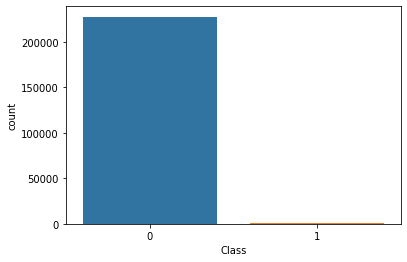

In [ ]:
ax = sns.countplot(x="Class", data=df_train)

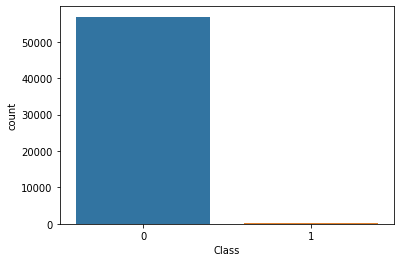

In [ ]:
bx = sns.countplot(x="Class", data=df_test)

In [ ]:
n_fraudulent_transactions = df_train['Class'].value_counts()[1]
print('Quantidade de transações fraudulentas no dataset de treino ({}) representando um total de ({})% do dataset'.format(n_fraudulent_transactions, (n_fraudulent_transactions/df_train.shape[0])*100))
n_fraudulent_transactions = df_test['Class'].value_counts()[1]
print('Quantidade de transações fraudulentas no dataset de teste ({}) representando um total de ({})% do dataset'.format(n_fraudulent_transactions, (n_fraudulent_transactions/df_test.shape[0])*100))

Quantidade de transações fraudulentas no dataset de treino (391) representando um total de (0.171607891329632)% do dataset
Quantidade de transações fraudulentas no dataset de teste (101) representando um total de (0.1773111899160844)% do dataset


In [ ]:
mic = mutual_info_classif(x_train, y_train)
mic

array([0.00223417, 0.00324333, 0.0048859 , 0.00493872, 0.0024805 ,
       0.00235812, 0.00385478, 0.00200889, 0.00420066, 0.00735391,
       0.00683457, 0.00754913, 0.00048603, 0.00795956, 0.00033733,
       0.00614541, 0.00819216, 0.00429184, 0.00147992, 0.00127442,
       0.00256113, 0.0004726 , 0.00081558, 0.00072547, 0.0006311 ,
       0.00054575, 0.00238648, 0.00180494, 0.00139201])

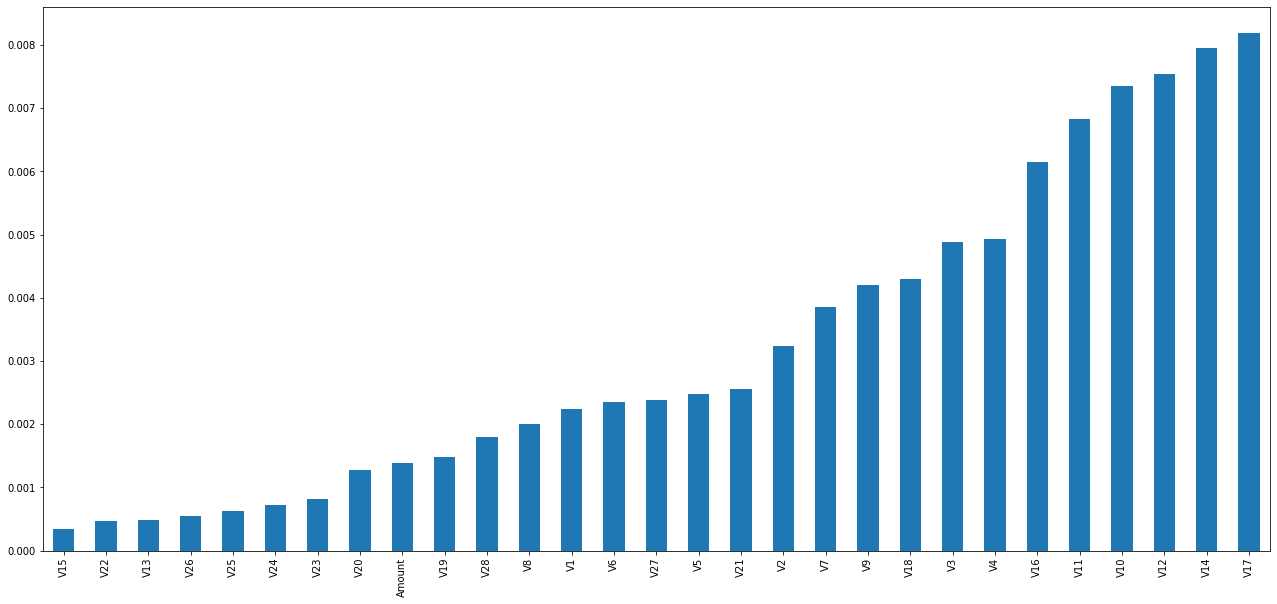

In [ ]:
mic = pd.Series(mic)
mic.index = x_train.columns
mic = mic.sort_values(ascending = True)
mic.plot.bar(figsize=(22,10))

In [ ]:
selection = SelectKBest(mutual_info_classif, k= 20).fit(x_train, y_train)
X_train = x_train[x_train.columns[selection.get_support()]]
X_test = x_test[x_test.columns[selection.get_support()]]

# Random Forest

- Treino com sample de treino

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

- Relatório de classificação da predição com o modelo Random forest com o sample de treino

In [ ]:
predictions = rf.predict(X_train)
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227454
           1       1.00      1.00      1.00       391

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845



- Matriz de confusão dos valores preditos com o conjunto de treino

In [ ]:
pd.crosstab(y_train, predictions, rownames=['Real'],colnames=['Predito'],margins=True)

Predito,0,1,All
Real,,,
0,227454,0,227454
1,0,391,391
All,227454,391,227845


- Validação cruzada utilizando 5 pastas

In [ ]:
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
scores

array([0.99960499, 0.99940749, 0.99964888, 0.99951722, 0.99949527])

- Media dos scores obtidos

In [ ]:
scores.mean()

0.9995347714455003

- Acurácia do modelo

In [ ]:
accuracy_score(y_train, predictions)

1.0

- Root Mean Squared Error (RMSE) 

In [ ]:
rmse = sqrt(mean_squared_error(y_train, predictions))
rmse

0.0

- Curva ROC

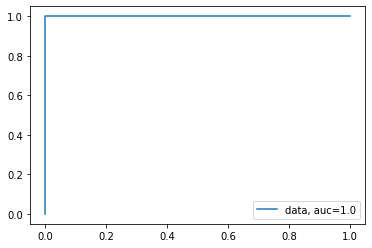

In [ ]:
cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    rf.fit(X[train], y[train])
    viz = plot_roc_curve(rf, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

- Predição do sample de teste

In [ ]:
predictions_test = rf.predict(X_test)

- Relatório de classificação da predição com o modelo Random forest com o sample de teste

In [ ]:
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.93      0.79      0.86       101

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



- Matriz de confusão dos valores preditos com o conjunto de teste

In [ ]:
pd.crosstab(y_test, predictions_test, rownames=['Real'],colnames=['Predito'],margins=True) 

Predito,0,1,All
Real,,,
0,56855,6,56861
1,21,80,101
All,56876,86,56962


- Validação cruzada utilizando 5 pastas com conjunto de teste

In [ ]:
scores = cross_val_score(rf, X_test, predictions_test, cv=5, scoring='accuracy')
scores

array([0.99973668, 0.99964891, 0.99982444, 0.9995611 , 0.99991222])

- Media dos scores obtidos com o conjunto de teste

In [ ]:
scores.mean()

0.9996839995507788

- Acurácia do modelo

In [ ]:
accuracy_score(y_test, predictions_test)

0.9995259997893332

- Root Mean Squared Error (RMSE)

In [ ]:
rmse = sqrt(mean_squared_error(y_test, predictions_test))
rmse

0.021771545895199088

- Curva ROC, conjunto de teste

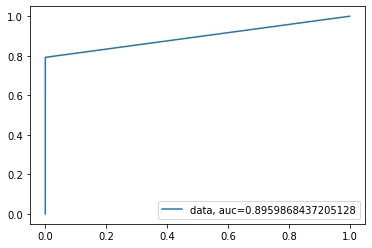

In [ ]:
fpr, tpr, _ = roc_curve(y_test, predictions_test)
auc =  roc_auc_score(y_test, predictions_test)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# KNN 

In [ ]:
k_range = range(1,26)
scores = {}
scores_list = []

In [ ]:
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_train)
  scores[k] = accuracy_score(y_train, y_pred)
  scores_list.append(accuracy_score(y_train, y_pred))

In [ ]:
plt.plot(k_range, scores_list)
plt.xlabel('Value of k for KNN')
plt.ylabel('Testing Accuracy')

In [ ]:
y_pred = 
print(classification_report(y_train, y_pred))

In [ ]:
pd.crosstab(y_train, y_pred, rownames=['Real'],colnames=['Predito'],margins=True)

In [ ]:
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
scores

In [ ]:
scores.mean()

In [ ]:
accuracy_score(y_train, y_pred)

In [ ]:
rmse = sqrt(mean_squared_error(y_train, y_pred))
rmse

In [ ]:
fpr, tpr, _ = roc_curve(y_train, y_pred)
auc =  roc_auc_score(y_train, y_pred)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# MLPClassifier

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(x_test)

In [ ]:
 print(classification_report(y_train, y_pred))

In [ ]:
pd.crosstab(y_train, y_pred, rownames=['Real'],colnames=['Predito'],margins=True)

In [ ]:
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
scores

In [ ]:
scores.mean()

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
rmse = sqrt(mean_squared_error(y_train, y_pred))
rmse

In [ ]:
fpr, tpr, _ = roc_curve(y_train, y_pred)
auc =  roc_auc_score(y_train, y_pred)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()